# Step 1: multipage tif to 3D arrays in HDF5.
The images get in as multipage tiffs, where every page is a slice in the z-direction. I want to store all elements in a single h5 file

In [11]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import h5torch

In [12]:
stacks_path = Path("../data/stacks")
paths = list(stacks_path.glob("*.tif"))

In [13]:
def extract_images(path: Path):
    """Read all pages of a tif file and put them in an array (pages, y, x)"""
    return np.array(cv2.imreadmulti(str(path))[1])

In [14]:
def get_strain_and_stress(sample_id: int):
    path = f"../data/curves/{sample_id}.csv"
    df = pd.read_csv(path)
    strain = df["strain"].to_numpy()
    stress = df["stress"].to_numpy()
    return np.stack([strain, stress])

In [15]:
def get_person_id(sample_id: int):
    path = "../data/targets.csv"
    df = pd.read_csv(path)
    return int(df[df["sample"] == sample_id]["person_id"].iloc[0])


In [16]:
def logistic(x, a, k, xc):
    return a / (1 + np.exp(-k * (x - xc)))

In [17]:
def fit_fun_to_data(fun, x, y):
    popt, _ = curve_fit(fun, x, y, maxfev=10000)
    return popt

In [18]:
out_path = "../data/stacks.h5t"
images = []
sample_ids = []
person_ids = []
strains, stresses = [], []
As, ks, xcs = [], [], []
for path in paths:
    try:
        sample_id = int(path.stem)
        person_id = get_person_id(sample_id)
        img = extract_images(path)
        strain, stress = get_strain_and_stress(sample_id)
        a, k, xc = fit_fun_to_data(logistic, strain, stress)
    except (FileNotFoundError, IndexError):
        continue
    else:
        sample_ids.append(sample_id)
        person_ids.append(person_id)
        images.append(img)
        strains.append(strain)
        stresses.append(stress)
        As.append(a)
        ks.append(k)
        xcs.append(xc)
    
    # if len(As) > 1:
    #     break

f =  h5torch.File(out_path, "w")
f.register(images, "central", mode="separate")
f.register(np.array(sample_ids, dtype=np.uint8), 0, name="sample_id")
f.register(np.array(person_ids, dtype=np.uint8), 0, name="person_id")
f.register(strains, 0, name="strain", mode="separate")
f.register(stresses, 0, name="stress", mode="separate")
As = np.array(As)
ks = np.array(ks)
xcs = np.array(xcs)
f.register(As, 0, name="a")
f.register(ks, 0, name="k")
f.register(xcs, 0, name="xc")
f.close()

C:\Users\z405155\AppData\Local\Temp\ipykernel_13024\388091049.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-k * (x - xc)))
C:\Users\z405155\AppData\Local\Temp\ipykernel_13024\388091049.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-k * (x - xc)))
C:\Users\z405155\AppData\Local\Temp\ipykernel_13024\388091049.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-k * (x - xc)))
c:\Users\z405155\AppData\Local\miniforge3\envs\skinstression\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\z405155\AppData\Local\Temp\ipykernel_13024\388091049.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-k * (x - xc)))
C:\Users\z405155\AppData\Local\Temp\ipykernel_13024\388091049.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.

In [6]:
out_path = "../data/stacks.h5t"
dataset = h5torch.Dataset(out_path)
dataset[0].keys()

dict_keys(['central', '0/a', '0/k', '0/person_id', '0/sample_id', '0/strain', '0/stress', '0/xc'])

The HDF5 file has the following structure to be read with h5torch:
```json
[
    { (for every sample a dataset)
        "central": array with images images (uint8),
        "0/sample_id": uint8,
        ... # See keys of output
    },
    ...
]
```

# Step 2: Make splits

In [48]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GroupKFold

In [80]:
gss = GroupShuffleSplit(1, random_state=42)
gkf = GroupKFold(5)
dataset = h5torch.Dataset(out_path)
train_super_idx, test_idx = next(gss.split(dataset.indices, groups=[sample["0/person_id"] for sample in dataset]))
dataset.close()
dataset = h5torch.Dataset(out_path, subset=train_super_idx)
k = 0
list(gkf.split(dataset.indices, groups=[sample["0/person_id"] for sample in dataset]))[k]
# for train_idx, val_idx in gkf.split(dataset.indices, groups=[sample["0/person_id"] for sample in dataset]):
    # print(train_idx, val_idx)
dataset.close()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37]), array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]))


In [81]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    import matplotlib.pyplot as plt
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        cmap_cv = plt.cm.coolwarm

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    cmap_data = plt.cm.Paired

    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["group"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(y)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<Axes: title={'center': 'GroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

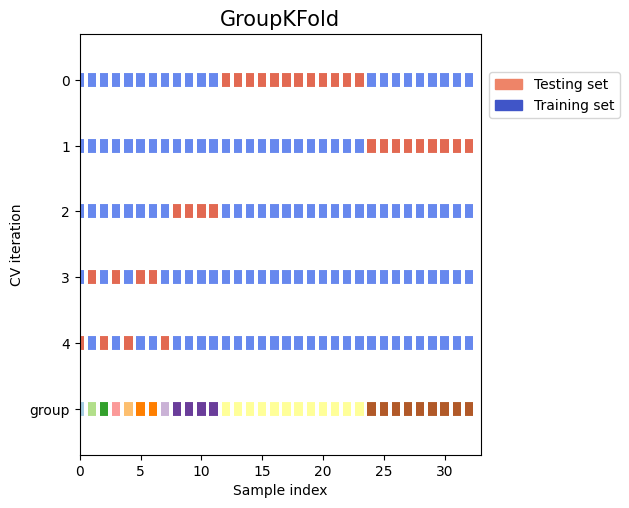

In [68]:
import matplotlib.pyplot as plt
cmap_cv = plt.cm.coolwarm
from matplotlib.patches import Patch
fig, ax = plt.subplots()
dataset = h5torch.Dataset(out_path, subset=train_super_idx)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plot_cv_indices(gkf, dataset.indices, dataset.indices, [sample["0/person_id"] for sample in dataset], ax, 5)